In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing all the necessary Packages and Libraries

## Installations

In [ ]:
pip install BioPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached biopython-1.80-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)


In [ ]:
pip install propy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 14.6 MB/s 


In [ ]:
pip install pyfaidx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 16.1 MB/s 
  Created wheel for pyfaidx: filename=pyfaidx-0.7.1-py3-none-any.whl size=27748 sha256=3cbb5420e84be77d8309b7367123fdea1ab52747413de2536b6f83a4135f1fa0
  Stored in directory: /root/.cache/pip/wheels/1a/d6/99/7334c4d11bfb574e6d6ea706256053b268a12f2127af1cfd40
Successfully built pyfaidx


## Imports for peptide feature extraction

In [ ]:
# Compute protein descriptors
from propy import PyPro
from propy import AAComposition
from propy import CTD


# Build Sequence Object
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Read Fasta File
from pyfaidx import Fasta

# Grouping iterable
from itertools import chain

# Return file path
import glob

/usr/local/lib/python3.7/dist-packages/propy/__init__.py:29: UserWarning: Python 3.6 and Python 3.7 might get deprecated. Please participate in the discussion: https://github.com/MartinThoma/propy3/issues/12
  "Python 3.6 and Python 3.7 might get deprecated. "


## Imports for ML

In [ ]:
# Import necessary packages

import pandas as pd
import numpy as np
import json 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

# Importing data and Extracting the Features

In [ ]:
positiveDf = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/positive.csv').drop('Unnamed: 0', axis=1)
negativeDf = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/negative.csv').drop('Unnamed: 0', axis=1)

# Concatenate both dataframes
peptideDf = pd.concat([negativeDf, positiveDf])
peptideDf.columns

Index(['Name', 'Seq', 'SeqLength', 'Weight', 'Aromaticity', 'Instability',
       'IsoelectricPoint', 'A', 'R', 'N',
       ...
       '_HydrophobicityD2025', '_HydrophobicityD2050', '_HydrophobicityD2075',
       '_HydrophobicityD2100', '_HydrophobicityD3001', '_HydrophobicityD3025',
       '_HydrophobicityD3050', '_HydrophobicityD3075', '_HydrophobicityD3100',
       'Class'],
      dtype='object', length=575)

In [ ]:
classes, freq = np.unique(peptideDf['Class'], return_counts=True)

print(f'The class {classes[0]} contains {freq[0]} samples')
print(f'The class {classes[1]} contains {freq[1]} samples')

print(f'The ratio of negative and positive: {round(freq[0]/freq[1],2)} : {freq[1]/freq[1]}')

The class 0 contains 2270 samples
The class 1 contains 227 samples
The ratio of negative and positive: 10.0 : 1.0


We can see that we have more negatives than the positives. The negatives are 10 times the positives.

# Preprocessing

In [ ]:
# remove highly correlated features

remove = ['Weight','AS', 'AP', 'RM', 'RA', 'AS', 'AV', 'AY', 'RW', 'RY', 'NR', 'NA', 'RV', 'EW', 'EM', 'EF', 'EP', 'ES', 'ET', 'GN', 'GQ', 'EW', 'QW', 'QM', 'QF', 'QP', 'QS', 'QT', 'QW']
peptideDf.drop(remove,axis=1,inplace=True)

In [ ]:
peptideDf.shape

(2497, 549)

## Splitting the datasets

In [ ]:
y = peptideDf['Class']
X = peptideDf.drop(['Name','Seq','Class'],axis=1)

# Printing the shape of the dataframe
print('Shape of X: ',X.shape[0],X.shape[1])
print('Shape of y: ',y.shape[0])

# Splitting the data
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.20, random_state=1, stratify=y_)

# Printing the shape of each sets
print('\nTraining set:   ',X_train.shape[0])
print('Validation set: ',X_valid.shape[0])
print('Testing set:    ',X_test.shape[0])

Shape of X:  2497 546
Shape of y:  2497

Training set:    1597
Validation set:  400
Testing set:     500


Splitting the datasets 
* First we split the datasets into train and test datasets. 
* Second, We again split the train dataset into train and validation datasets.

Reason
* We should keep the test data untouched until we experiment with the validation dataset and decide the best model.

## Normalization

In [ ]:
# Preprocessing 

scaler = MinMaxScaler()
scaler.fit(X_)
X_mms =  pd.DataFrame(scaler.transform(X_), index=X_.index, columns=X_.columns)
X_train_mms =  pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_valid_mms =  pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
X_test_mms = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:
values_train,freq_train = np.unique(y_train, return_counts=True)
print('Training  ', values_train,freq_train)

values_valid,freq_valid = np.unique(y_valid, return_counts=True)
print('Validation',values_valid,freq_valid)

values_test,freq_test = np.unique(y_test, return_counts=True)
print('Testing   ',values_test,freq_test)

Training   [0 1] [1451  146]
Validation [0 1] [364  36]
Testing    [0 1] [455  45]


# Baseline Model

In [ ]:
def modelling(optimized_model, allModel, X_train,y_train,X_valid,y_valid, X_test,y_test):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allModel) to store results 
    for different models, and train, validation and test features and the target as an input.
    
    For each model the function trains the model with train dataset and predict the target for train, test and 
    validation datasets. 
    
    The performance of each dataset is evaluated and added to the dataframe which will be the output for the function"""
    
    # Assign the model and train the data
    model = optimized_model['model']
    model.fit(X_train,y_train)
    
    # Predict the target using trained model
    y_pred_train = model.predict(X_train)    
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    
    # Training data
    cm_train = confusion_matrix(y_train, y_pred_train)
    TN, TP, FP, FN = cm_train[0][0], cm_train[1][1], cm_train[0][1], cm_train[1][0]
    precision_train = TP/(FP+TP)*100
    recall_train = TP/(FN+TP)*100
    f1_positive_train = f1_score(y_train, y_pred_train)*100
    mcc_train = matthews_corrcoef(y_train, y_pred_train)*100
    
     # Calculating Precision and Recall for validation data
    cm_valid = confusion_matrix(y_valid, y_pred_valid)
    TN, TP, FP, FN = cm_valid[0][0], cm_valid[1][1], cm_valid[0][1], cm_valid[1][0]
    precision_valid = TP/(FP+TP)*100
    recall_valid = TP/(FN+TP)*100
    f1_positive_valid = f1_score(y_valid, y_pred_valid)*100
    mcc_valid = matthews_corrcoef(y_valid, y_pred_valid)*100

     # Calculating Precision and Recall for test data
    cm_test = confusion_matrix(y_test, y_pred_test)
    TN, TP, FP, FN = cm_test[0][0], cm_test[1][1], cm_test[0][1], cm_test[1][0]
    precision_test = TP/(FP+TP)*100
    recall_test = TP/(FN+TP)*100
    f1_positive_test = f1_score(y_test, y_pred_test)*100
    mcc_test = matthews_corrcoef(y_test, y_pred_test)*100
    
    # create new dictionary for the current model and convert it into dataframe
    currentModel = {'Name':optimized_model['name'], 'Train F1 Positive':f1_positive_train, 
                'Train MCC Score' : mcc_train, 'Train Precision':precision_train, 'Train Recall':recall_train,
                'Validation F1 Positive':f1_positive_valid, 'Validation MCC Score' : mcc_valid,
                'Validation Precision':precision_valid, 'Validation Recall':recall_valid,
                'Test F1 Positive':f1_positive_test, 'Test MCC Score' : mcc_test,
                'Test Precision':precision_test, 'Test Recall':mcc_test}

    currentModel = pd.DataFrame(currentModel, index=[0])
    
    # Concatenate currentModel dataframe to allModel dataframe
    allModel = pd.concat([allModel,currentModel], ignore_index=True)

    # Print Confusion Matrix
    print(optimized_model['name'])

    plot_confusion_matrix(model, X_train, y_train)
    plt.title('Training')  
    plt.show()

    plot_confusion_matrix(model, X_valid, y_valid)
    plt.title('Validation')  
    plt.show()

    plot_confusion_matrix(model, X_test, y_test)
    plt.title('Testing')  
    plt.show()
    
    return allModel



def kfold_modelling(optimized_model, allKFold, X, y):
    
    """ The function gets a dictionary for the model (optimized_model), empty dataframe (allKFold) to store results 
    for different models, and full dataset features and the target as an input.
    
    For each model the function splits the datasets into 10 batches of train and test datasets. Each batches of data
    is then used to train and test the model. The performance of the model is evaluated for each batches and collected in
    a dataframe. The mean of all 10 batches are calculated and stored in a currentKFold dataframe which is then concatenated
    to the main dataframe allKFold."""
    
    # Assign the model and train the data
    model = optimized_model['model']
    # model.fit(X,y)
    
    # Call StratifiedKFold function to split the data
    skf = StratifiedKFold(n_splits=5, random_state=32, shuffle=True)
    
    # Creating empty dictionary to store 10 batches of performance metrics
    tempDf = pd.DataFrame()
    
    # Using for loop to loop through 10 batches
    for train_index, test_index in skf.split(X,y):
        # Generate train and test sets
        X_train_kfold, X_valid_kfold = X.iloc[train_index], X.iloc[test_index]
        y_train_kfold, y_valid_kfold = y.iloc[train_index], y.iloc[test_index]

        # Model Fitting
        model.fit(X_train_kfold,y_train_kfold)
        
        # Now we make the predictions on both the training and test sets of the model.
        y_pred_train_kfold = model.predict(X_train_kfold)
        y_pred_valid_kfold = model.predict(X_valid_kfold)
        
        # Evaluate Validation set
        cm_valid = confusion_matrix(y_valid_kfold, y_pred_valid_kfold)
        TN, TP, FP, FN = cm_valid[0][0], cm_valid[1][1], cm_valid[0][1], cm_valid[1][0]
        precision_valid = TP/(FP+TP)*100
        recall_valid = TP/(FN+TP)*100
        f1_positive_valid = f1_score(y_valid_kfold, y_pred_valid_kfold)*100
        mcc_valid = matthews_corrcoef(y_valid_kfold, y_pred_valid_kfold)*100

        # Calculate Accuracy, F1, and MCC Values of the training set
        cm_train = confusion_matrix(y_train_kfold, y_pred_train_kfold)
        TN, TP, FP, FN = cm_train[0][0], cm_train[1][1], cm_train[0][1], cm_train[1][0]
        precision_train = TP/(FP+TP)*100
        recall_train = TP/(FN+TP)*100
        f1_positive_train = f1_score(y_train_kfold, y_pred_train_kfold)*100
        mcc_train = matthews_corrcoef(y_train_kfold, y_pred_train_kfold)*100
        
        # create a dictionary and dataframe to store the metrics of the current batch
        batchDict = {'Train F1 Positive':f1_positive_train, 'Train MCC Score' : mcc_train, 'Train Precision':precision_train, 'Train Recall':recall_train,
                 'Validation F1 Positive':f1_positive_valid, 'Validation MCC Score' : mcc_valid, 'Validation Precision':precision_valid, 'Validation Recall':recall_valid}
        batchDf = pd.DataFrame(batchDict, index=[0])
        # Concatenate the current batch metrics to temp dataframe to store all 10 batches metrics
        tempDf = pd.concat([tempDf,batchDf], ignore_index=True)
    
    # Mean values of the Validation set
    precision_mean_valid = tempDf['Validation Precision'].mean(axis=0)
    recall_mean_valid = tempDf['Validation Recall'].mean(axis=0)
    f1_positive_mean_valid = tempDf['Validation F1 Positive'].mean(axis=0)
    mcc_mean_valid = tempDf['Validation MCC Score'].mean(axis=0)

    # Mean values of the train set
    precision_mean_train = tempDf['Train Precision'].mean(axis=0)
    recall_mean_train = tempDf['Train Recall'].mean(axis=0)
    f1_positive_mean_train = tempDf['Train F1 Positive'].mean(axis=0)
    mcc_mean_train = tempDf['Train MCC Score'].mean(axis=0)
    
    # Collect the means in the dataframe
    currentKFold = {'Name':optimized_model['name'], 'Train F1 Positive':f1_positive_mean_train, 
                    'Train MCC Score' : mcc_mean_train, 'Train Precision':f1_positive_mean_train, 'Train Recall':recall_mean_train,
                    'Validation F1 Positive':f1_positive_mean_valid, 'Validation MCC Score' : mcc_mean_valid,
                    'Validation Precision':precision_mean_valid, 'Validation Recall':mcc_mean_valid}

    currentKFold = pd.DataFrame(currentKFold, index=[0])
    
    # Concatenate currentKFold dataframe to allKFold dataframe
    allKFold = pd.concat([allKFold, currentKFold], ignore_index=True)
    
    return allKFold

In [ ]:
"""Call the functions of the selected ML algorithms
   The parameters of each model are selected through Randomized Search CV method"""

svc_rbf = SVC()
random = RandomForestClassifier()
knn = KNeighborsClassifier()
xgb = XGBClassifier()

# Create dictionary for each models
svm_rbf_model = {'name':'SVM RBF','model':svc_rbf}
random_model = {'name':'Random Forest','model':random}
knn_model = {'name':'KNNeighbor','model':knn}
xgboost_model = {'name':'XGBooster','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, random_model, knn_model, xgboost_model]

SVM RBF


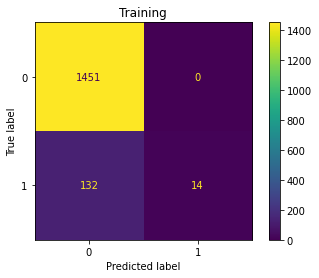

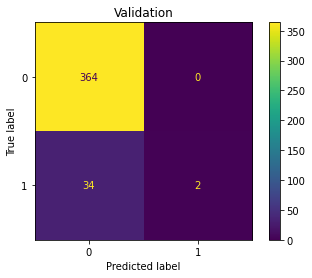

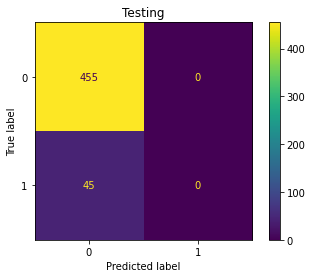

Random Forest


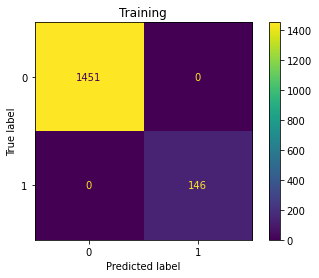

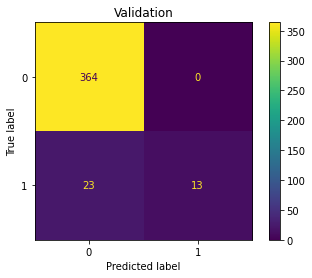

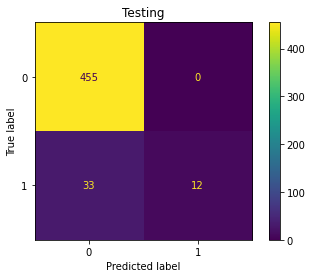

KNNeighbor


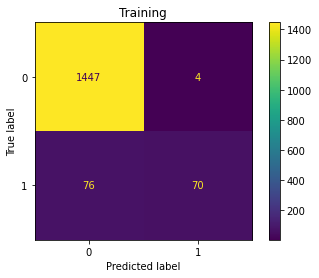

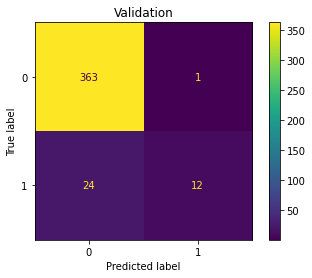

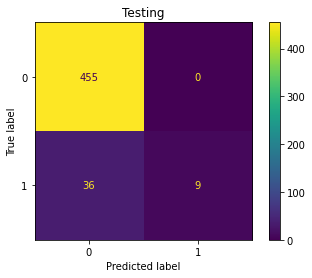

XGBooster


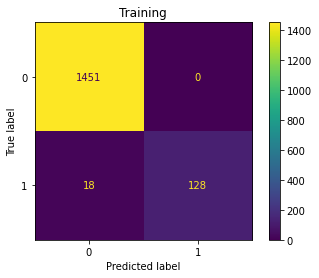

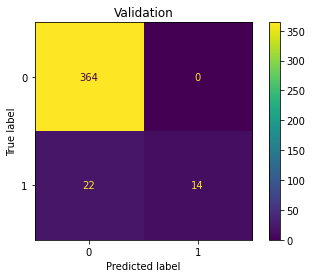

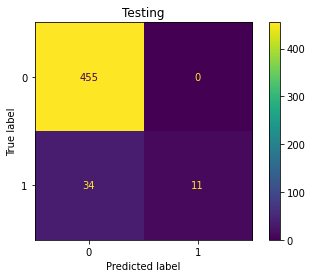

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall,Test F1 Positive,Test MCC Score,Test Precision,Test Recall
0,SVM RBF,17.500000,29.647006,100.000000,9.589041,10.526316,22.540986,100.000000,5.555556,0.000000,0.000000,NaN,0.000000
1,Random Forest,100.000000,100.000000,100.000000,100.000000,53.061224,58.279476,100.000000,36.111111,42.105263,49.863201,100.0,49.863201
2,KNNeighbor,63.636364,65.355964,94.594595,47.945205,48.979592,53.353062,92.307692,33.333333,33.333333,43.050673,100.0,43.050673
3,XGBooster,93.430657,93.057497,100.000000,87.671233,56.000000,60.557761,100.000000,38.888889,39.285714,47.691541,100.0,47.691541


In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating empty dataframe to store the performance metrics
df = pd.DataFrame()

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    df = modelling(i, df, X_train, y_train, X_valid, y_valid, X_test, y_test)
df

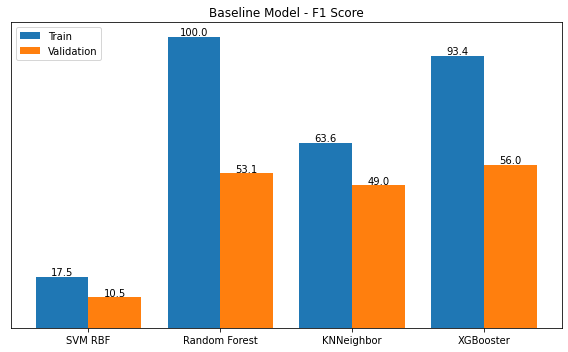

In [ ]:
model = df['Name']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, df['Train F1 Positive'], 0.4, label='f1 positive')     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, df['Validation F1 Positive'],0.4,  label='mcc')

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('Baseline Model - F1 Score')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

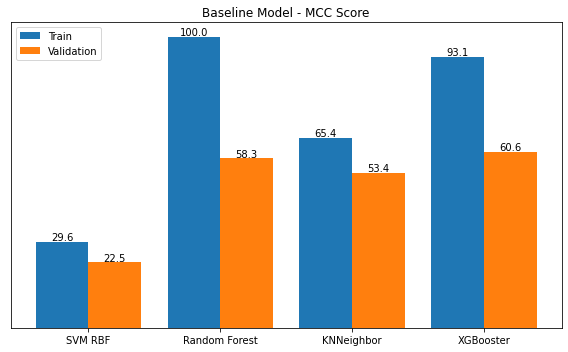

In [ ]:
model = df['Name']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, df['Train MCC Score'], 0.4, )     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, df['Validation MCC Score'],0.4)

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('Baseline Model - MCC Score')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [ ]:
# Creating empty dataframe to store the performance metrics of the KFold validation
kfold_df = pd.DataFrame()

# Loop through all the model and call modelling function to get the performance metrics of all the model
for i in all_models:
    kfold_df = kfold_modelling(i, kfold_df, X_, y_)
    
kfold_df

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,SVM RBF,15.691892,27.915607,15.691892,8.516769,14.233468,26.312668,100.000000,26.312668
1,Random Forest,100.000000,100.000000,100.000000,100.000000,64.857393,67.618800,100.000000,67.618800
2,KNNeighbor,60.780591,63.230122,60.780591,44.641474,55.626221,58.162256,90.578877,58.162256
3,XGBooster,92.507144,92.152525,92.507144,86.136042,63.260193,65.817634,97.552448,65.817634


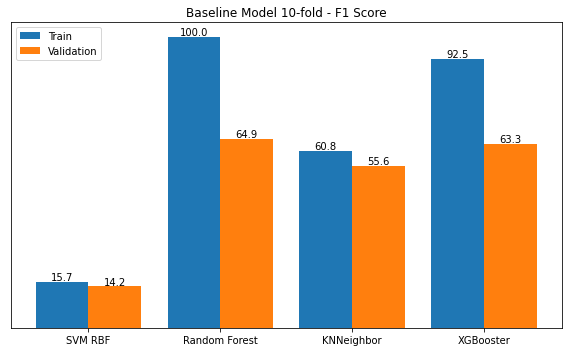

In [ ]:
model = kfold_df['Name']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, kfold_df['Train F1 Positive'], 0.4)     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, kfold_df['Validation F1 Positive'],0.4)

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('Baseline Model 10-fold - F1 Score')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

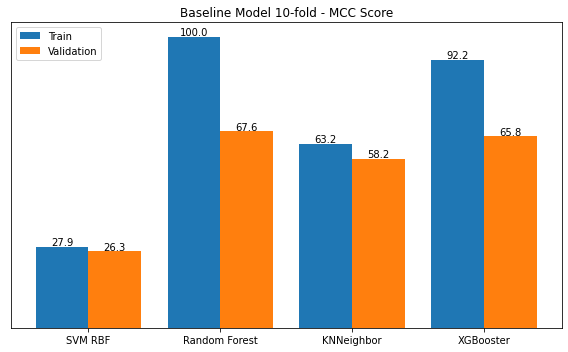

In [ ]:
model = kfold_df['Name']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, kfold_df['Train MCC Score'], 0.4, )     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, kfold_df['Validation MCC Score'],0.4)

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('Baseline Model 10-fold - MCC Score')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

# Data Proportion

In [ ]:
positive = positiveDf.drop(columns=['Name','Seq'])
negative = negativeDf.drop(columns=['Name','Seq'])

In [ ]:
n_pos = positive.shape[0]

kfold_df_rbf = pd.DataFrame()
scaler = MinMaxScaler()

for i in range(1,10):
  negativeDf_frac = negative.sample(n=n_pos*i, random_state=0)
  #print(negativeDf_frac.shape)
  # Combine the data
  peptideDf_frac = pd.concat([negativeDf_frac, positive])

  y_frac = peptideDf_frac['Class']
  X_frac = peptideDf_frac.drop(['Class'],axis=1)

  # Splitting the main dataset into training and validation sets
  X_frac_, X_test_frac, y_frac_, y_test_frac = train_test_split(X_frac, y_frac, test_size=0.19, random_state=42, stratify=y_frac)
  X_train_frac, X_valid_frac, y_train_frac, y_valid_frac = train_test_split(X_frac_, y_frac_, test_size=0.21, random_state=42, stratify=y_frac_)

  scaler.fit(X_frac_)

  X_mms_frac = pd.DataFrame(scaler.transform(X_frac_), index=X_frac_.index, columns=X_frac_.columns)
  X_train_mms_frac =  pd.DataFrame(scaler.transform(X_train_frac), index=X_train_frac.index, columns=X_train_frac.columns)
  X_valid_mms_frac =  pd.DataFrame(scaler.transform(X_valid_frac), index=X_valid_frac.index, columns=X_valid_frac.columns)
  X_test_mms_frac = pd.DataFrame(scaler.transform(X_test_frac), index=X_test_frac.index, columns=X_test_frac.columns)

  svm_rbf_model = {'name': '1:'+str(i),'model':svc_rbf}
  kfold_df_rbf = kfold_modelling(svm_rbf_model, kfold_df_rbf, X_mms_frac, y_frac_)

svm_rbf_model = {'name': '1:10','model':svc_rbf}
kfold_df_rbf = kfold_modelling(svm_rbf_model, kfold_df_rbf, X_, y_)
kfold_df_rbf

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,1:1,85.124513,73.695524,85.124513,78.394006,60.842612,31.633535,70.266667,31.633535
1,1:2,55.335429,54.069577,55.335429,38.313109,41.781170,43.215864,98.000000,43.215864
2,1:3,45.940034,49.163097,45.940034,29.894282,39.163153,44.086056,100.000000,44.086056
3,1:4,40.977275,46.616185,40.977275,25.818165,33.743961,40.887654,100.000000,40.887654
4,1:5,35.319776,43.043308,35.319776,21.470859,30.193313,39.000018,100.000000,39.000018
5,1:6,19.074982,29.944691,19.074982,10.737268,4.102564,8.639385,100.000000,8.639385
6,1:7,28.156764,37.803886,28.156764,16.706196,18.221349,26.935636,100.000000,26.935636
7,1:8,19.913147,31.181904,19.913147,11.283324,10.769607,19.424224,100.000000,19.424224
8,1:9,16.999539,27.917418,16.999539,9.652510,6.207827,13.332457,100.000000,13.332457
9,1:10,15.691892,27.915607,15.691892,8.516769,14.233468,26.312668,100.000000,26.312668


In [ ]:
n_pos = positive.shape[0]

kfold_df_random = pd.DataFrame()
scaler = MinMaxScaler()

for i in range(1,10):
  negativeDf_frac = negative.sample(n=n_pos*i, random_state=0)
  #print(negativeDf_frac.shape)
  # Combine the data
  peptideDf_frac = pd.concat([negativeDf_frac, positive])

  y_frac = peptideDf_frac['Class']
  X_frac = peptideDf_frac.drop(['Class'],axis=1)

  # Splitting the main dataset into training and validation sets
  X_frac_, X_test_frac, y_frac_, y_test_frac = train_test_split(X_frac, y_frac, test_size=0.19, random_state=42, stratify=y_frac)
  X_train_frac, X_valid_frac, y_train_frac, y_valid_frac = train_test_split(X_frac_, y_frac_, test_size=0.21, random_state=42, stratify=y_frac_)

  scaler.fit(X_frac_)

  X_mms_frac = pd.DataFrame(scaler.transform(X_frac_), index=X_frac_.index, columns=X_frac_.columns)
  X_train_mms_frac =  pd.DataFrame(scaler.transform(X_train_frac), index=X_train_frac.index, columns=X_train_frac.columns)
  X_valid_mms_frac =  pd.DataFrame(scaler.transform(X_valid_frac), index=X_valid_frac.index, columns=X_valid_frac.columns)
  X_test_mms_frac = pd.DataFrame(scaler.transform(X_test_frac), index=X_test_frac.index, columns=X_test_frac.columns)

  random_model = {'name': '1:'+str(i),'model':random}
  kfold_df_random = kfold_modelling(random_model, kfold_df_random, X_mms_frac, y_frac_)

random_model = {'name': '1:10','model':random}
kfold_df_random = kfold_modelling(random_model, kfold_df_random, X_, y_)
kfold_df_random

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,1:1,100.000000,100.000000,100.000000,100.000000,69.710525,46.420810,78.313231,46.420810
1,1:2,100.000000,100.000000,100.000000,100.000000,68.361768,61.346819,91.114468,61.346819
2,1:3,100.000000,100.000000,100.000000,100.000000,61.576168,58.678115,91.554113,58.678115
3,1:4,100.000000,100.000000,100.000000,100.000000,61.584934,61.279823,95.494987,61.279823
4,1:5,100.000000,100.000000,100.000000,100.000000,61.431611,62.657597,97.714286,62.657597
5,1:6,100.000000,100.000000,100.000000,100.000000,65.097329,66.164447,97.894737,66.164447
6,1:7,100.000000,100.000000,100.000000,100.000000,65.349206,66.607147,97.149758,66.607147
7,1:8,100.000000,100.000000,100.000000,100.000000,63.357107,66.004833,100.000000,66.004833
8,1:9,100.000000,100.000000,100.000000,100.000000,58.375879,62.209020,99.130435,62.209020
9,1:10,99.931271,99.924529,99.931271,99.863014,63.684156,66.408892,98.888889,66.408892


In [ ]:
n_pos = positive.shape[0]

kfold_df_knn = pd.DataFrame()
scaler = MinMaxScaler()

for i in range(1,10):
  negativeDf_frac = negative.sample(n=n_pos*i, random_state=0)
  #print(negativeDf_frac.shape)
  # Combine the data
  peptideDf_frac = pd.concat([negativeDf_frac, positive])

  y_frac = peptideDf_frac['Class']
  X_frac = peptideDf_frac.drop(['Class'],axis=1)

  # Splitting the main dataset into training and validation sets
  X_frac_, X_test_frac, y_frac_, y_test_frac = train_test_split(X_frac, y_frac, test_size=0.19, random_state=42, stratify=y_frac)
  X_train_frac, X_valid_frac, y_train_frac, y_valid_frac = train_test_split(X_frac_, y_frac_, test_size=0.21, random_state=42, stratify=y_frac_)

  scaler.fit(X_frac_)

  X_mms_frac = pd.DataFrame(scaler.transform(X_frac_), index=X_frac_.index, columns=X_frac_.columns)
  X_train_mms_frac =  pd.DataFrame(scaler.transform(X_train_frac), index=X_train_frac.index, columns=X_train_frac.columns)
  X_valid_mms_frac =  pd.DataFrame(scaler.transform(X_valid_frac), index=X_valid_frac.index, columns=X_valid_frac.columns)
  X_test_mms_frac = pd.DataFrame(scaler.transform(X_test_frac), index=X_test_frac.index, columns=X_test_frac.columns)

  knn_model = {'name': '1:'+str(i),'model':knn}
  kfold_df_knn = kfold_modelling(knn_model, kfold_df_knn, X_mms_frac, y_frac_)

knn_model = {'name':'1:10','model':knn}
kfold_df_knn = kfold_modelling(knn_model, kfold_df_knn, X_, y_)
kfold_df_knn

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,1:1,70.057697,26.247403,70.057697,97.418643,67.460935,12.425544,52.126801,12.425544
1,1:2,57.739615,30.702537,57.739615,94.431881,52.434054,15.908255,37.238697,15.908255
2,1:3,49.397596,29.505816,49.397596,91.711712,44.476771,18.204098,29.907026,18.204098
3,1:4,45.268168,29.888525,45.268168,84.236073,38.453972,17.174655,25.768231,17.174655
4,1:5,41.441708,29.007238,41.441708,80.569038,34.206000,16.474398,22.462301,16.474398
5,1:6,35.677458,24.654965,35.677458,79.886008,28.795301,12.106668,18.018047,12.106668
6,1:7,34.720801,26.071821,34.720801,77.718331,26.619104,12.511043,16.609539,12.511043
7,1:8,33.333480,26.238839,33.333480,75.814488,26.205404,15.230025,16.209524,15.230025
8,1:9,41.388839,35.162103,41.388839,62.774407,28.943431,19.699691,20.485761,19.699691
9,1:10,60.780591,63.230122,60.780591,44.641474,55.626221,58.162256,90.578877,58.162256


In [ ]:
n_pos = positive.shape[0]

kfold_df_xgb = pd.DataFrame()
scaler = MinMaxScaler()

for i in range(1,10):
  negativeDf_frac = negative.sample(n=n_pos*i, random_state=0)
  #print(negativeDf_frac.shape)
  # Combine the data
  peptideDf_frac = pd.concat([negativeDf_frac, positive])

  y_frac = peptideDf_frac['Class']
  X_frac = peptideDf_frac.drop(['Class'],axis=1)

  # Splitting the main dataset into training and validation sets
  X_frac_, X_test_frac, y_frac_, y_test_frac = train_test_split(X_frac, y_frac, test_size=0.19, random_state=42, stratify=y_frac)
  X_train_frac, X_valid_frac, y_train_frac, y_valid_frac = train_test_split(X_frac_, y_frac_, test_size=0.21, random_state=42, stratify=y_frac_)

  scaler.fit(X_frac_)

  X_mms_frac = pd.DataFrame(scaler.transform(X_frac_), index=X_frac_.index, columns=X_frac_.columns)
  X_train_mms_frac =  pd.DataFrame(scaler.transform(X_train_frac), index=X_train_frac.index, columns=X_train_frac.columns)
  X_valid_mms_frac =  pd.DataFrame(scaler.transform(X_valid_frac), index=X_valid_frac.index, columns=X_valid_frac.columns)
  X_test_mms_frac = pd.DataFrame(scaler.transform(X_test_frac), index=X_test_frac.index, columns=X_test_frac.columns)

  xgb_model = {'name': '1:'+str(i),'model':xgb}
  kfold_df_xgb = kfold_modelling(xgb_model, kfold_df_xgb, X_mms_frac, y_frac_)

xgboost_model = {'name':'1:10','model':xgb}
kfold_df_xgb = kfold_modelling(xgboost_model, kfold_df_xgb, X_, y_)
kfold_df_xgb

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,1:1,100.000000,100.000000,100.000000,100.000000,69.258844,41.839287,72.808437,41.839287
1,1:2,100.000000,100.000000,100.000000,100.000000,68.081143,57.294567,81.459811,57.294567
2,1:3,99.863481,99.818593,99.863481,99.727891,60.782756,56.432547,86.844953,56.432547
3,1:4,99.521714,99.405206,99.521714,99.049458,64.033187,63.491113,96.096257,63.491113
4,1:5,99.104575,98.936825,99.104575,98.233131,57.474229,57.826451,91.934641,57.826451
5,1:6,97.340877,96.964295,97.340877,94.835448,62.404437,63.668478,96.712418,63.668478
6,1:7,96.627030,96.234957,96.627030,93.476742,63.033549,64.956904,98.047619,64.956904
7,1:8,96.326760,95.976180,96.326760,92.938040,62.069033,64.191305,96.586257,64.191305
8,1:9,93.933771,93.524659,93.933771,88.591653,55.256554,59.316110,97.333333,59.316110
9,1:10,92.507144,92.152525,92.507144,86.136042,63.260193,65.817634,97.552448,65.817634


# SMOTE

In [ ]:
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(X, y)

# Printing the shape of the dataframe
print('Shape of X: ',X_smote.shape[0],X_smote.shape[1])
print('Shape of y: ',y.shape[0])

# Splitting the data
X_smote_, X_test_smote, y_smote_, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.20, random_state=1, stratify=y_smote)
X_train_smote, X_valid_smote, y_train_smote, y_valid_smote = train_test_split(X_smote_, y_smote_, test_size=0.20, random_state=1, stratify=y_smote_)

# Printing the shape of each sets
print('\nTraining set:   ',X_train_smote.shape[0])
print('Validation set: ',X_valid_smote.shape[0])
print('Testing set:    ',X_test_smote.shape[0])

Shape of X:  4540 546
Shape of y:  2497

Training set:    2905
Validation set:  727
Testing set:     908


In [ ]:
# Preprocessing 

scaler = MinMaxScaler()
scaler.fit(X_smote_)
X_smote_mms =  pd.DataFrame(scaler.transform(X_smote_), index=X_smote_.index, columns=X_smote_.columns)
X_train_smote_mms =  pd.DataFrame(scaler.transform(X_train_smote), index=X_train_smote.index, columns=X_train_smote.columns)
X_valid_smote_mms =  pd.DataFrame(scaler.transform(X_valid_smote), index=X_valid_smote.index, columns=X_valid_smote.columns)
X_test_smote_mms = pd.DataFrame(scaler.transform(X_test_smote), index=X_test_smote.index, columns=X_test_smote.columns)

In [ ]:
values_train,freq_train = np.unique(y_train_smote, return_counts=True)
print('Training  ', values_train,freq_train)

values_valid,freq_valid = np.unique(y_valid_smote, return_counts=True)
print('Validation',values_valid,freq_valid)

values_test,freq_test = np.unique(y_test_smote, return_counts=True)
print('Testing   ',values_test,freq_test)

Training   [0 1] [1453 1452]
Validation [0 1] [363 364]
Testing    [0 1] [454 454]


In [ ]:
# Create dictionary for each models
svm_rbf_model = {'name':'SVM_SMOTE','model':svc_rbf}
random_model = {'name':'Random_SMOTE','model':random}
knn_model = {'name':'KNN_SMOTE','model':knn}
xgboost_model = {'name':'XGB_SMOTE','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, random_model, knn_model, xgboost_model]

In [ ]:
kfold_smote = pd.DataFrame()
for i in all_models:
  kfold_smote = kfold_modelling(i, kfold_smote, X_smote_mms, y_smote_)
kfold_smote

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,SVM_SMOTE,94.098815,88.163636,94.098815,94.396973,91.766856,83.374279,90.591116,83.374279
1,Random_SMOTE,100.000000,100.000000,100.000000,100.000000,98.941566,97.929461,99.943503,97.929461
2,KNN_SMOTE,70.934281,31.491751,70.934281,100.000000,69.632196,26.115526,53.412238,26.115526
3,XGB_SMOTE,98.977753,97.996510,98.977753,97.976316,97.419554,94.998131,99.257916,94.998131


In [ ]:
# RBF
svm_rbf_model = {'name': 'SMOTE','model':svc_rbf}
kfold_df_rbf = kfold_modelling(svm_rbf_model, kfold_df_rbf, X_smote_mms, y_smote_)

# Random
random_model = {'name': 'SMOTE','model':random}
kfold_df_random = kfold_modelling(random_model, kfold_df_random, X_smote_mms, y_smote_)

# KNN
knn_model = {'name':'SMOTE','model':knn}
kfold_df_knn = kfold_modelling(knn_model, kfold_df_knn, X_smote_mms, y_smote_)

# XGB
xgboost_model = {'name':'SMOTE','model':xgb}
kfold_df_xgb = kfold_modelling(xgboost_model, kfold_df_xgb, X_smote_mms, y_smote_)

# Visualization of different proportion of dataset

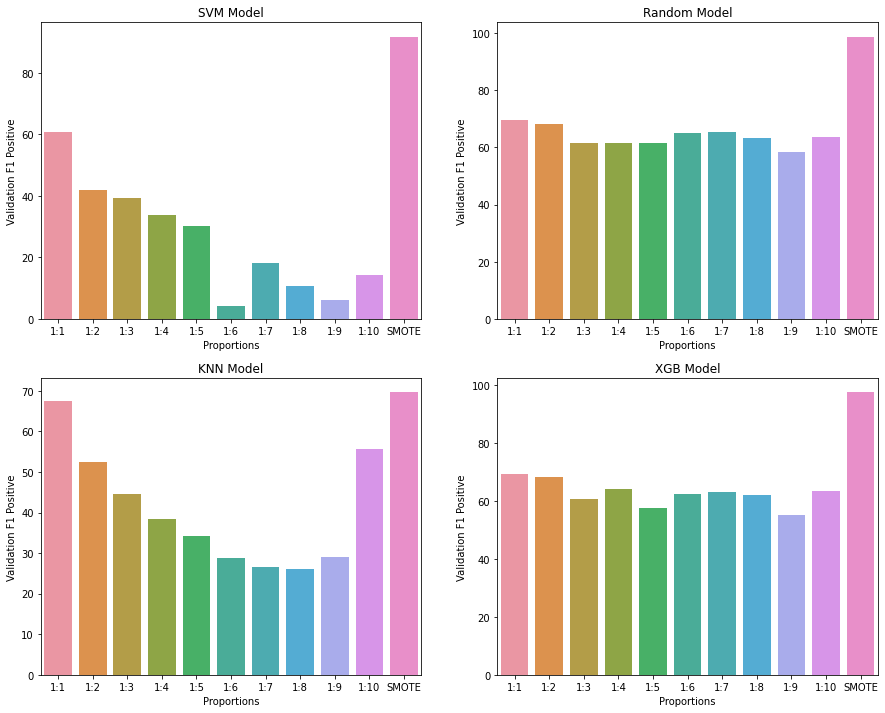

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,12))

sns.barplot(kfold_df_rbf['Name'], kfold_df_rbf['Validation F1 Positive'], ax=ax[0,0]).set(title='SVM Model')
sns.barplot(kfold_df_random['Name'], kfold_df_random['Validation F1 Positive'], ax=ax[0,1]).set(title='Random Model')
sns.barplot(kfold_df_knn['Name'], kfold_df_knn['Validation F1 Positive'], ax=ax[1,0]).set(title='KNN Model')
sns.barplot(kfold_df_xgb['Name'], kfold_df_xgb['Validation F1 Positive'], ax=ax[1,1]).set(title='XGB Model')

ax[0,0].set(xlabel='Proportions')
ax[0,1].set(xlabel='Proportions')
ax[1,0].set(xlabel='Proportions')
ax[1,1].set(xlabel='Proportions')

# fig.suptitle('10-fold Validation - F1 Score')
plt.show()

# Feature Reduction

In [ ]:
# Feature Importance 
random = RandomForestClassifier(random_state=42)
random.fit(X_smote_mms, y_smote_)
importances = random.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

# pd.set_option('display.max_rows',None)
# forest_importances

In [ ]:
forest_importances= forest_importances.sort_values(ascending=False)

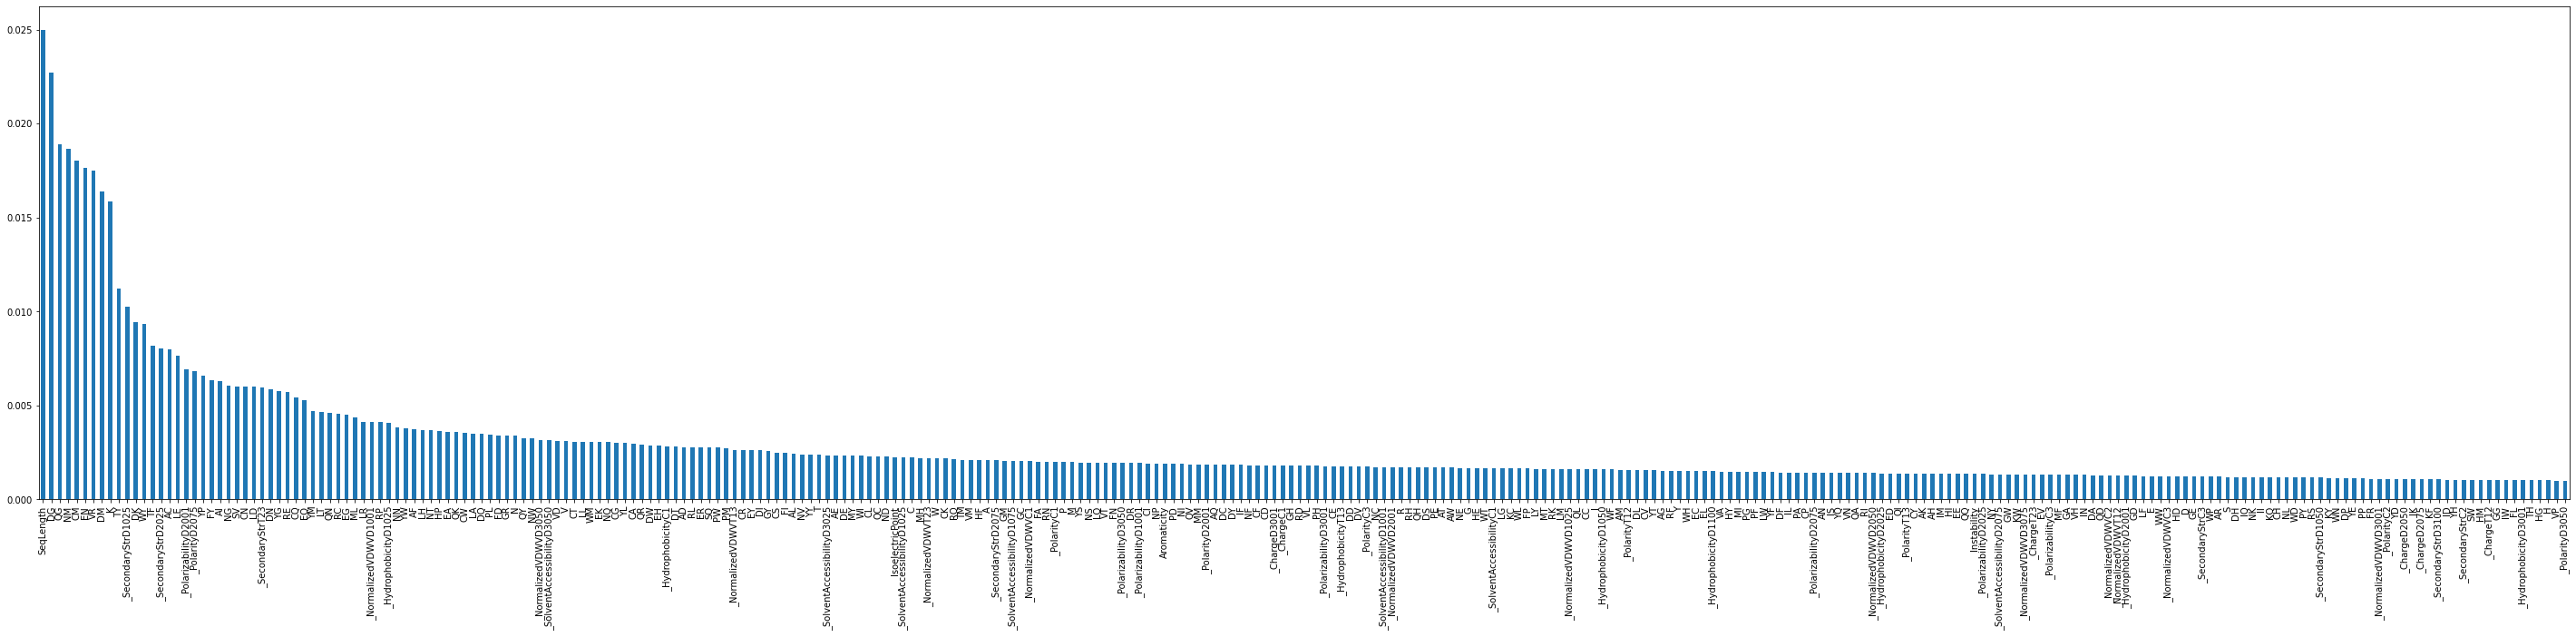

In [ ]:
fig, ax = plt.subplots(figsize=[50,10])
forest_importances[forest_importances > 0.001].plot.bar(ax=ax)

plt.show()

In [ ]:
selected_features = forest_importances[forest_importances > 0.001].index
selected_features

Index(['SeqLength', 'Aromaticity', 'Instability', 'IsoelectricPoint', 'A', 'R',
       'N', 'D', 'C', 'E',
       ...
       '_NormalizedVDWVD1025', '_NormalizedVDWVD2050', '_NormalizedVDWVD2100',
       '_NormalizedVDWVD3025', '_NormalizedVDWVD3050', '_HydrophobicityD1025',
       '_HydrophobicityD2001', '_HydrophobicityD2025', '_HydrophobicityD2075',
       '_HydrophobicityD3025'],
      dtype='object', length=303)

In [ ]:
# Create dictionary for each models
svm_rbf_model = {'name':'SVM_SMOTE_SF','model':svc_rbf}
random_model = {'name':'Random_SMOTE_SF','model':random}
knn_model = {'name':'KNN_SMOTE_SF','model':knn}
xgboost_model = {'name':'XGB_SMOTE_SF','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, random_model, knn_model, xgboost_model]

kfold_smote_sf = pd.DataFrame()
for i in all_models:
  kfold_smote_sf = kfold_modelling(i, kfold_smote_sf, X_smote_mms[selected_features], y_smote_)
kfold_smote_sf

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,SVM_SMOTE_SF,90.902054,81.791812,90.902054,91.010354,88.877064,77.719845,88.470461,77.719845
1,Random_SMOTE_SF,100.000000,100.000000,100.000000,100.000000,98.942504,97.927468,99.943503,97.927468
2,KNN_SMOTE_SF,75.616096,46.456890,75.616096,100.000000,73.303155,39.614804,57.859691,39.614804
3,XGB_SMOTE_SF,98.984792,98.010027,98.984792,97.990118,97.415637,95.008474,99.371968,95.008474


In [ ]:
kfold_smote

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,SVM_SMOTE,94.098815,88.163636,94.098815,94.396973,91.766856,83.374279,90.591116,83.374279
1,Random_SMOTE,100.000000,100.000000,100.000000,100.000000,98.941566,97.929461,99.943503,97.929461
2,KNN_SMOTE,70.934281,31.491751,70.934281,100.000000,69.632196,26.115526,53.412238,26.115526
3,XGB_SMOTE,98.977753,97.996510,98.977753,97.976316,97.419554,94.998131,99.257916,94.998131


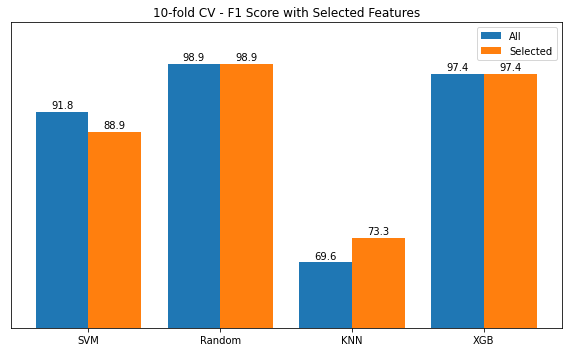

In [ ]:
model = ['SVM', 'Random', 'KNN', 'XGB']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, kfold_smote['Validation F1 Positive'], 0.4)     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, kfold_smote_sf['Validation F1 Positive'],0.4)

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('10-fold CV - F1 Score with Selected Features')
plt.legend(['All', 'Selected'])
plt.ylim([60,105])
plt.tight_layout()
plt.show()

# PCA

In [ ]:
pca = PCA()
pca.fit(X_smote_mms)

pca_df = pd.DataFrame({'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)})
pca_df = pca_df.transpose()
pca_df.columns = ['PC{}'.format(i) for i in range(1, len(pca_df.columns) + 1)]
pd.set_option('display.max_columns',None)
pca_df.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,PC186,PC187,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228,PC229,PC230,PC231,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244,PC245,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300,PC301,PC302,PC303,PC304,PC305,PC306,PC307,PC308,PC309,PC310,PC311,PC312,PC313,PC314,PC315,PC316,PC317,PC318,PC319,PC320,PC321,PC322,PC323,PC324,PC325,PC326,PC327,PC328,PC329,PC330,PC331,PC332,PC333,PC334,PC335,PC336,PC337,PC338,PC339,PC340,PC341,PC342,PC343,PC344,PC345,PC346,PC347,PC348,PC349,PC350,PC351,PC352,PC353,PC354,PC355,PC356,PC357,PC358,PC359,PC360,PC361,PC362,PC363,PC364,PC365,PC366,PC367,PC368,PC369,PC370,PC371,PC372,PC373,PC374,PC375,PC376,PC377,PC378,PC379,PC380,PC381,PC382,PC383,PC384,PC385,PC386,PC387,PC388,PC389,PC390,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400,PC401,PC402,PC403,PC404,PC405,PC406,PC407,PC408,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418,PC419,PC420,PC421,PC422,PC423,PC424,PC425,PC426,PC427,PC428,PC429,PC430,PC431,PC432,PC433,PC434,PC435,PC436,PC437,PC438,PC439,PC440,PC441,PC442,PC443,PC444,PC445,PC446,PC447,PC448,PC449,PC450,PC451,PC452,PC453,PC454,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464,PC465,PC466,PC467,PC468,PC469,PC470,PC471,PC472,PC473,PC474,PC475,PC476,PC477,PC478,PC479,PC480,PC481,PC482,PC483,PC484,PC485,PC486,PC487,PC488,PC489,PC490,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500,PC501,PC502,PC503,PC504,PC505,PC506,PC507,PC508,PC509,PC510,PC511,PC512,PC513,PC514,PC515,PC516,PC517,PC518,PC519,PC520,PC521,PC522,PC523,PC524,PC525,PC526,PC527,PC528,PC529,PC530,PC531,PC532,PC533,PC534,PC535,PC536,PC537,PC538,PC539,PC540,PC541,PC542,PC543,PC544,PC545,PC546
Cumulative proportion,0.0507,0.0954,0.1284,0.1565,0.181,0.2034,0.2223,0.2396,0.2545,0.2687,0.2822,0.2946,0.3066,0.3172,0.3275,0.3374,0.3469,0.3561,0.3647,0.3728,0.3807,0.3883,0.3957,0.403,0.41,0.4167,0.4233,0.4298,0.4361,0.4422,0.4481,0.4538,0.4596,0.4651,0.4705,0.4758,0.4811,0.4862,0.4913,0.4963,0.5012,0.506,0.5107,0.5152,0.5198,0.5242,0.5287,0.5331,0.5374,0.5416,0.5458,0.55,0.5541,0.558,0.5619,0.5658,0.5696,0.5734,0.5772,0.5809,0.5846,0.5882,0.5918,0.5954,0.5989,0.6023,0.6057,0.6091,0.6125,0.6158,0.6191,0.6223,0.6255,0.6286,0.6318,0.6348,0.6378,0.6409,0.6438,0.6468,0.6497,0.6526,0.6554,0.6583,0.6611,0.6638,0.6666,0.6693,0.6719,0.6746,0.6772,0.6799,0.6825,0.685,0.6876,0.6901,0.6926,0.6951,0.6976,0.7001,0.7025,0.7049,0.7073,0.7097,0.712,0.7144,0.7167,0.719,0.7212,0.7235,0.7257,0.7279,0.7301,0.7323,0.7345,0.7366,0.7387,0

Selecting 289 components based on the cumulative proportion of 95%

In [ ]:
Xpca = pd.DataFrame(pca.fit_transform(X_smote_mms))
Xpca = Xpca.iloc[:,:289]

# Create dictionary for each models
svm_rbf_model = {'name':'SVM_SMOTE_PCA','model':svc_rbf}
random_model = {'name':'Random_SMOTE_PCA','model':random}
knn_model = {'name':'KNN_SMOTE_PCA','model':knn}
xgboost_model = {'name':'XGB_SMOTE_PCA','model':xgb}

# collect all the models in a list
all_models = [svm_rbf_model, random_model, knn_model, xgboost_model]

kfold_smote_pca = pd.DataFrame()
for i in all_models:
  kfold_smote_pca = kfold_modelling(i, kfold_smote_pca, Xpca, y_smote_)
kfold_smote_pca

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall
0,SVM_SMOTE_PCA,99.841700,99.683395,99.841700,99.848561,98.849384,97.692255,98.365098,97.692255
1,Random_SMOTE_PCA,100.000000,100.000000,100.000000,100.000000,98.941013,97.931533,100.000000,97.931533
2,KNN_SMOTE_PCA,72.848390,38.183734,72.848390,100.000000,71.412817,33.262758,55.537300,33.262758
3,XGB_SMOTE_PCA,99.986226,99.972475,99.986226,99.972461,98.584660,97.203163,99.274644,97.203163


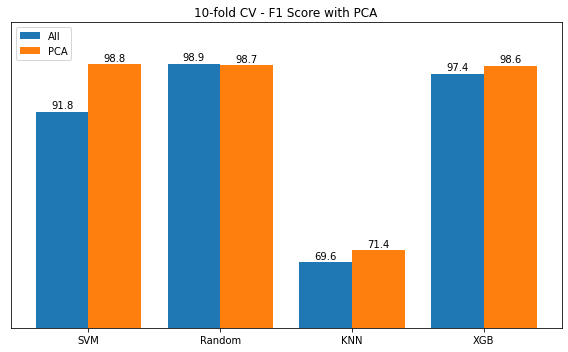

In [ ]:
model = ['SVM', 'Random', 'KNN', 'XGB']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, kfold_smote['Validation F1 Positive'], 0.4)     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, kfold_smote_pca['Validation F1 Positive'],0.4)

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('10-fold CV - F1 Score with PCA')
plt.legend(['All', 'PCA'], loc = 'upper left')
plt.ylim([60,105])
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

## Function

In [ ]:
def hypertune(model_parameter, niter=100 ,X=X_train_smote_mms, y=y_train_smote):
  
  model = model_parameter['model']
  parameter = model_parameter['params']
  #print(parameter)
  

  scores = {'f1': f1_score}
  cv = StratifiedKFold(n_splits = 5)

  # Fit to select best parameters
  search = RandomizedSearchCV(model, parameter, n_iter=niter, scoring=make_scorer(scores['f1']), cv=cv, random_state=42, return_train_score = True,
                              n_jobs=4, verbose=2)
  search.fit(X,y)
  
  # Get Attributes
  attr = {}
  attr['rank'] = search.cv_results_['rank_test_score']
  attr['test_means'] = search.cv_results_['mean_test_score']
  attr['test_stds'] = search.cv_results_['std_test_score']
  attr['train_means'] = search.cv_results_['mean_train_score']
  attr['train_stds'] = search.cv_results_['std_train_score']
  attr['params'] = search.cv_results_['params']

  return attr

### SVC RBF Kernel

In [ ]:
parameter = {'gamma' : np.arange(0.001, 10, 0.001), 'C' :  np.arange(0.01, 5, 0.01) }

svc_rbf = {'name': 'SVM w/RBF Kernel', 'model': SVC(), 'params': parameter}

SvcRbfAtrributes = pd.DataFrame(hypertune(svc_rbf))
C = []
gamma = []
for y in SvcRbfAtrributes['params']:
  C.append(y['C'])
  gamma.append(y['gamma'])

SvcRbfAtrributes['C'] = C
SvcRbfAtrributes['gamma'] = gamma
SvcRbfAtrributes.drop(columns=['params'], inplace=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
# Do this if necessary

# Save the hyperparameter attributes in the dataframe
SvcRbfAtrributes.to_csv("/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/SvcRbfAtrributes.csv",index=False)

In [ ]:
# Load the dataframe
SvcRbfAtrributes = pd.read_csv("/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/SvcRbfAtrributes.csv")

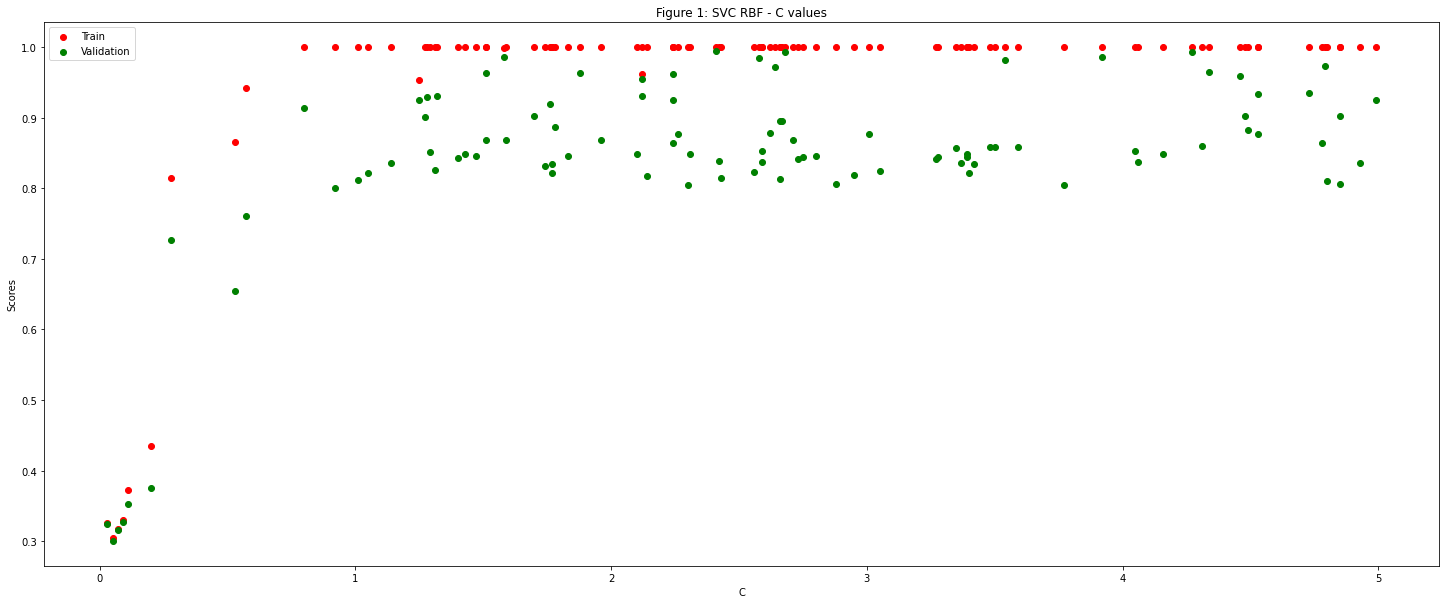

In [ ]:
# Plot MCC Score vs C
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcRbfAtrributes['C'], SvcRbfAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])       # Note: we consider test scores in the df as validation scores, to avoid conflict as we have test data untouched for this process
plt.title('Figure 1: SVC RBF - C values')
plt.show()

**Figure 1 - SVM RBF Kernel - Validation MCC vs C**

*Observation*
- The validation score increases linearly until C becomes 0.5 approximately.
- The score reaches the threshold and doesn't increase for higher values of C.
- After C=0.9 the model overfits.
- Between the 80-100% of the scores, there are few parameters for which the train and validation scores are near to each other.

*Sol: Look at the values little closer. For validation score between 80-100%, and avoid points for which the model overfits*

*Note: It will be interesting to look at the gamma value for the selected data points*

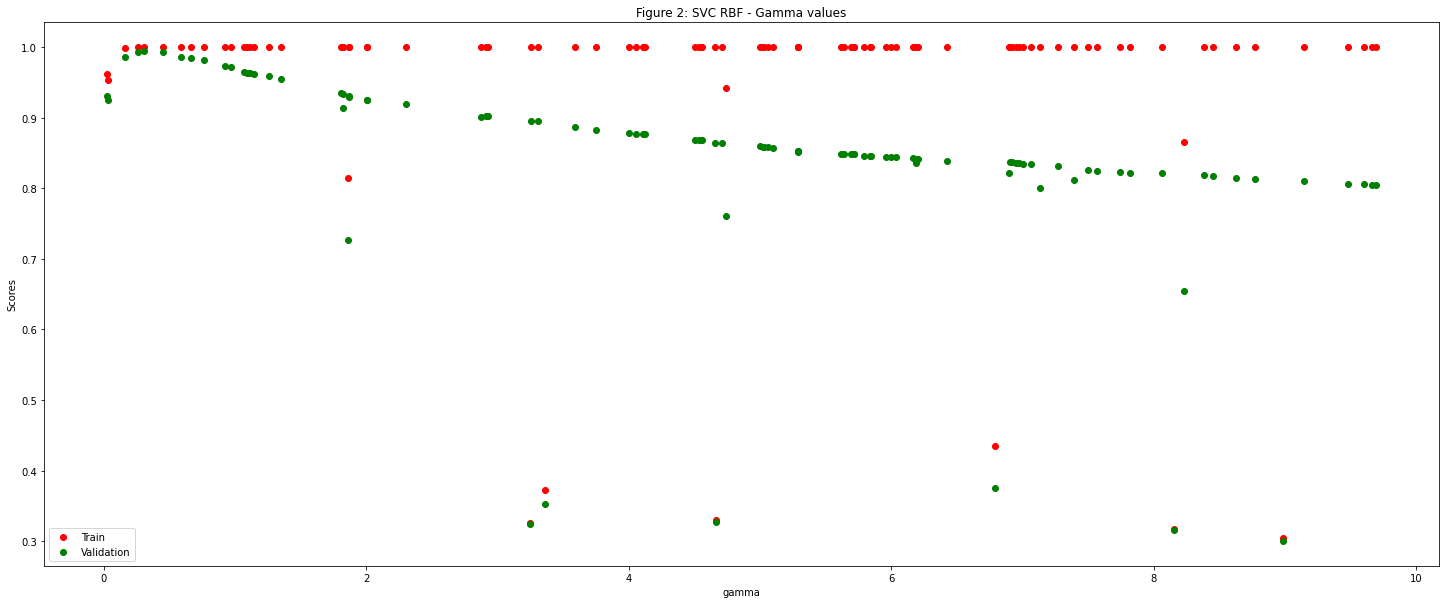

In [ ]:
# Plot MCC Score vs Gamma
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(SvcRbfAtrributes['gamma'], SvcRbfAtrributes['train_means'], marker ='o', color='r')
ax.scatter(SvcRbfAtrributes['gamma'], SvcRbfAtrributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('gamma')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 2: SVC RBF - Gamma values')
plt.show()

**Figure 2 - SVM RBF Kernel - Validation MCC vs Gamma**

*Observation*
- We can see an exponential decrease in the validation score for gamma value around 1.
- For higher value of gamma, the score decreases very slightly and the model starts to overfit.

*Sol: Look at the values little closer. For validation score between 80-100%, and avoid points for which the model overfits*

In [ ]:
# Create another column 'diff' that shows the difference between train and the validation scores

SvcRbfAtrributes['diff'] = SvcRbfAtrributes['train_means'] - SvcRbfAtrributes['test_means']
SvcRbfAtrributes = SvcRbfAtrributes[(SvcRbfAtrributes['test_means'] >= 0.8) & (SvcRbfAtrributes['train_means'] != 1)]
SvcRbfAtrributes.sort_values(by = ['diff','test_stds'])

,rank,test_means,test_stds,train_means,train_stds,C,gamma,diff
4,5,0.985584,0.006880,0.999052,0.000323,1.58,0.164,0.013468
7,21,0.924552,0.008646,0.953836,0.001536,1.25,0.036,0.029285
95,18,0.930343,0.008228,0.961249,0.001566,2.12,0.030,0.030907


_Note: By choosing the validation score more than 80%, we eliminated higher gamma values. We can see that the gamma value is not more than 0.3_

Selection criterion for hyperparameters:
- The validation (test_means) score must be high and should have less variations between validation and test scores.
- The standard deviations of scores must be minimum. 
- We can see the hyperparameter ranked 6 satisfies the conditions.

**Selected hyperparameter**

**(C=1.25, gamma=0.036)**

In [ ]:
svcRbfAllFeaturesParameter = {'name': 'SVM RBF', 'model': SVC(C=1.25, gamma=0.036)}

### Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')

n_estimators = list(range(10,500,10))
max_features = ['auto','sqrt']
max_depth = list(range(2,20,1))
max_samples = np.arange(0.1,1.1,0.1)
bootstrap = [True]
class_weight = ['balanced', 'None']

parameter = {'n_estimators'   : n_estimators, 
               'max_features' : max_features,
               'max_depth'    : max_depth,
               'max_samples'  : max_samples,
               'bootstrap'    : bootstrap,
               'class_weight' : class_weight}

random_forest = {'name': 'Random Forest', 'model': rf, 'params': parameter}

RandomAtrributes = pd.DataFrame(hypertune(random_forest))

# Splitting the parameters in the dataframe
n_estimators = []
max_samples = []
max_features = []
max_depth = []
bootstrap = []
for y in RandomAtrributes['params']:
  n_estimators.append(y['n_estimators'])
  max_samples.append(y['max_samples'])
  max_features.append(y['max_features'])
  max_depth.append(y['max_depth'])

RandomAtrributes['n_estimators'] = n_estimators
RandomAtrributes['max_samples'] = max_samples
RandomAtrributes['max_features'] = max_features
RandomAtrributes['max_depth'] = max_depth
RandomAtrributes.drop(columns=['params'], inplace=True)

RandomAtrributes.to_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/RandomAtrributes.csv', index=False)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1275 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1275 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 367, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 762, in _validate_y_class_weight
    % self.class_weight
ValueError: Val

In [ ]:
RfAttributes = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/RandomAtrributes.csv')

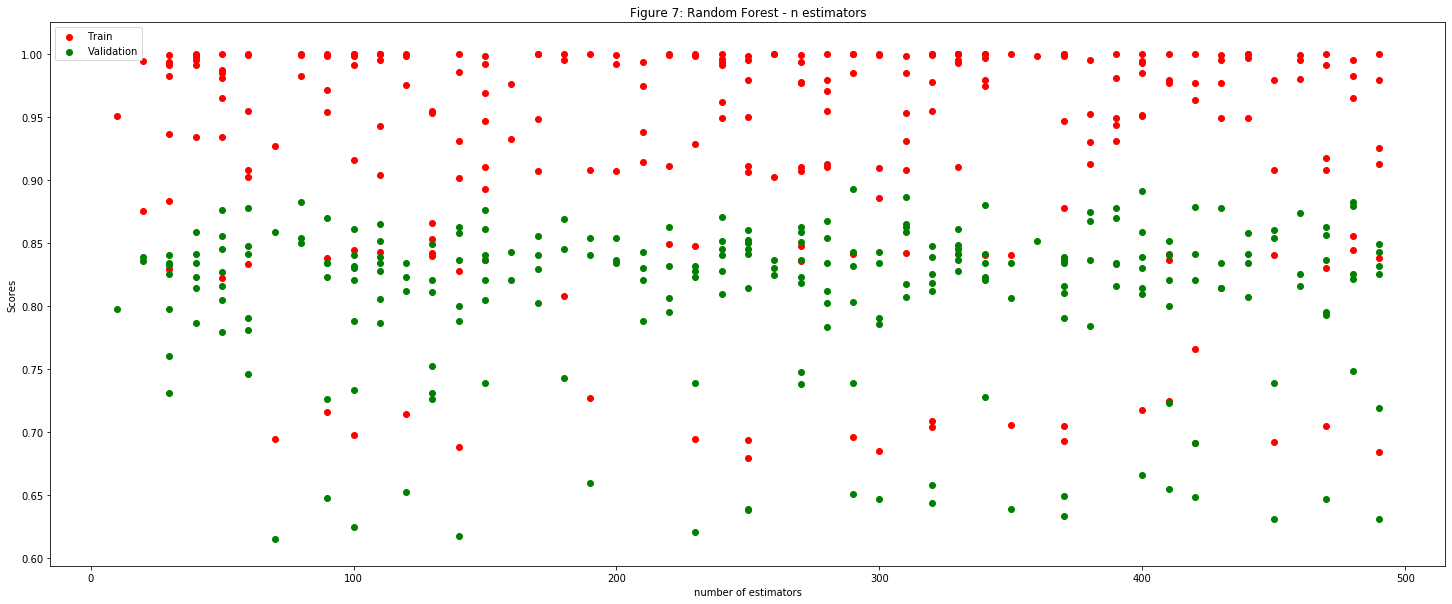

In [ ]:
# Plot number of estimator vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['n_estimators'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['n_estimators'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('number of estimators')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 7: Random Forest - n estimators')
plt.show()

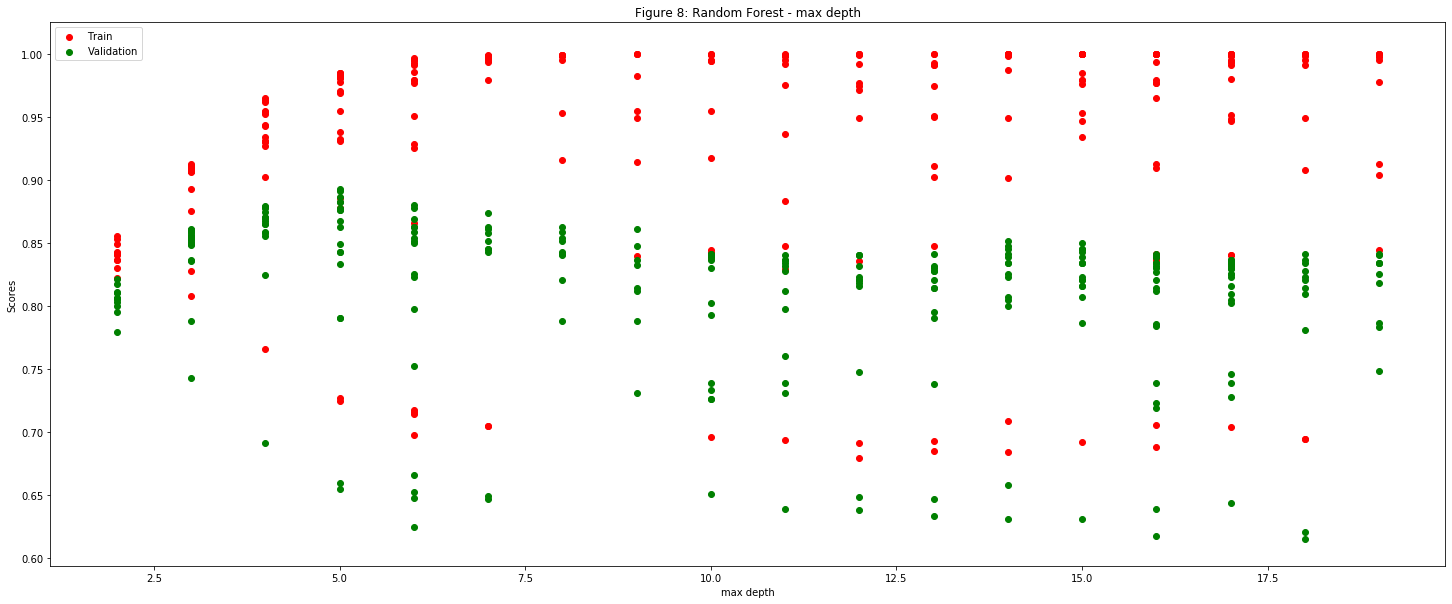

In [ ]:
# Plot depth vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['max_depth'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['max_depth'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('max depth')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 8: Random Forest - max depth')
plt.show()

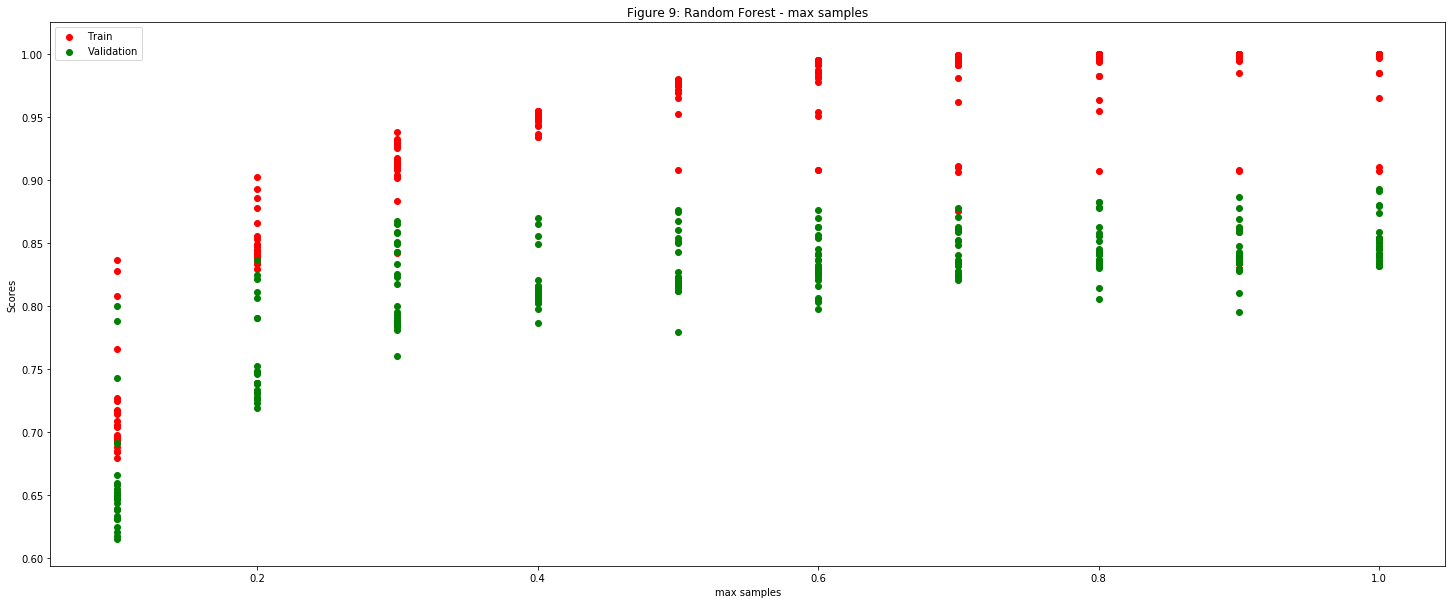

In [ ]:
# Plot Samples vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['max_samples'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['max_samples'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('max samples')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 9: Random Forest - max samples')
plt.show()

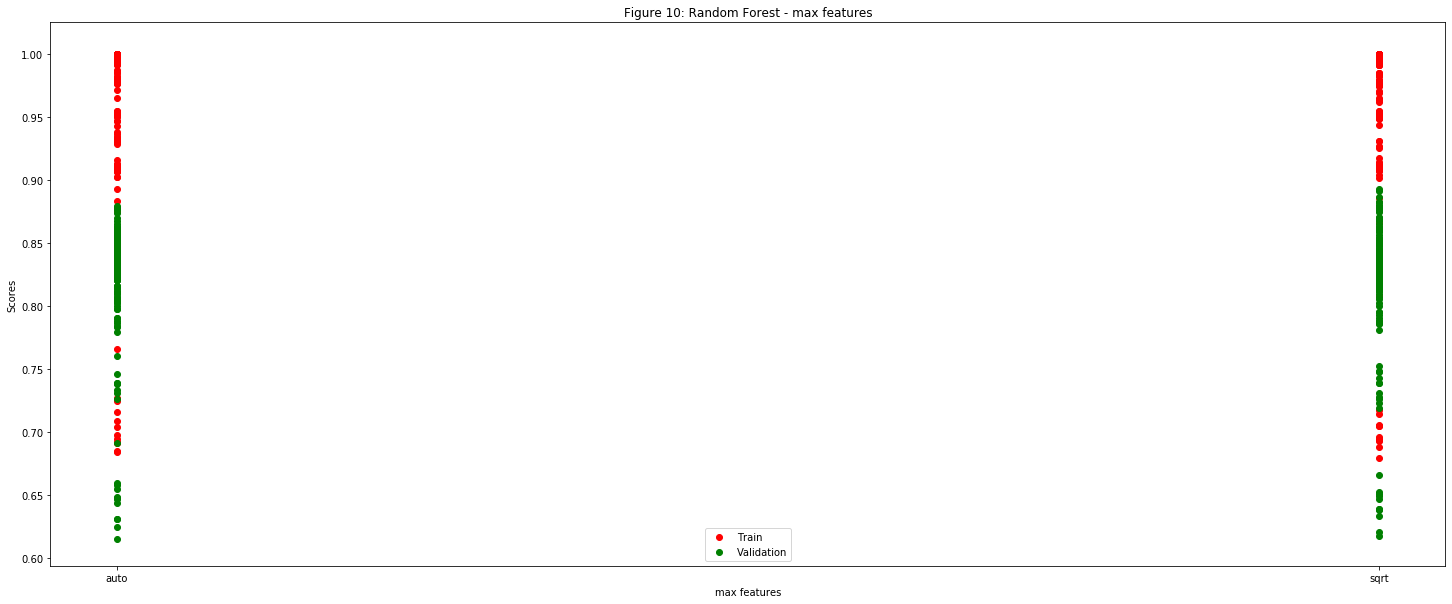

In [ ]:
# Plot features vs validation score
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(RfAttributes['max_features'], RfAttributes['train_means'], marker ='o', color='r')
ax.scatter(RfAttributes['max_features'], RfAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('max features')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 10: Random Forest - max features')
plt.show()

In [ ]:
RfAttributes = RfAttributes[(RfAttributes['test_means'] >= 0.85) & (RfAttributes['train_means'] != 1)]
RfAttributes['diff'] = RfAttributes['train_means'] - RfAttributes['test_means']

RfAttributes.sort_values(by=['diff', 'test_stds'])

,rank,test_means,test_stds,train_means,train_stds,n_estimators,max_samples,max_features,max_depth,diff
94,15,0.981425,0.003661,0.999742,0.000211,260,0.6,auto,10,0.018317
41,50,0.885937,0.012796,0.904360,0.001851,180,0.3,sqrt,3,0.018423
34,16,0.981404,0.006295,0.999914,0.000172,410,0.5,auto,13,0.018510
69,18,0.979622,0.006116,0.999742,0.000211,460,0.5,sqrt,10,0.020120
4,19,0.979607,0.006298,0.999828,0.000211,440,0.4,auto,19,0.020221
90,20,0.978587,0.005735,0.999397,0.000211,390,0.4,auto,13,0.020810
25,22,0.976837,0.007005,0.998361,0.000791,270,0.3,sqrt,13,0.021524
23,52,0.879238,0.025381,0.901167,0.007305,430,0.6,auto,3,0.021930
47,21,0.977178,0.007996,0.999655,0.000322,410,0.4,sqrt,15,0.022477
45,51,0.882915,0.014205,0.906068,0.006688,420,0.1,auto,3,0.023152


In [ ]:
RandomAllFeaturesParameter = {'name': 'Random', 'model': RandomForestClassifier(class_weight = 'balanced', bootstrap = True,n_estimators = 260, max_samples = 0.6, max_features = 'auto', max_depth = 10)}

### KNN

In [ ]:
knn = KNeighborsClassifier()
parameter = {'n_neighbors' : range(1,21), 'weights' : ['uniform', 'distance']}

knn = {'name': 'KNN', 'model': knn, 'params': parameter}

knnAttributes = pd.DataFrame(hypertune(knn))
n_neighbors = []
weights = []

for y in knnAttributes['params']:
  n_neighbors.append(y['n_neighbors'])
  weights.append(y['weights'])

knnAttributes['n_neighbors'] = n_neighbors
knnAttributes['weights'] = weights
knnAttributes.drop(columns=['params'], inplace=True)

knnAttributes.to_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/knnAttributes.csv', index=False)

In [ ]:
knnAttributes = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/knnAttributes.csv')


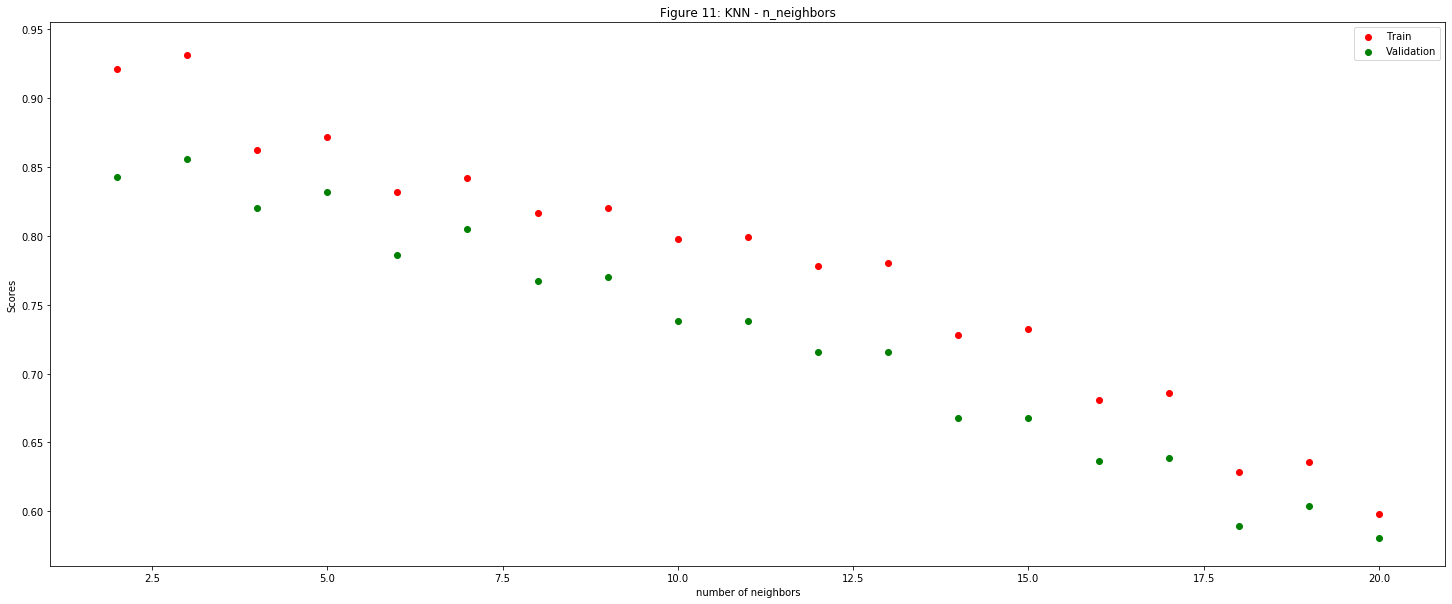

In [ ]:
# Plot validation score vs n neighbors
fig,ax = plt.subplots(1,1,figsize=[25,10])
ax.scatter(knnAttributes['n_neighbors'], knnAttributes['train_means'], marker ='o', color='r')
ax.scatter(knnAttributes['n_neighbors'], knnAttributes['test_means'], marker = 'o', color = 'g')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('Scores')
plt.legend(['Train', 'Validation'])
plt.title('Figure 11: KNN - n_neighbors')
plt.show()

In [ ]:
knnAttributes = knnAttributes[knnAttributes['train_means'] != 1]
knnAttributes['diff'] = knnAttributes['train_means'] - knnAttributes['test_means']
knnAttributes.sort_values(by=['test_means'], ascending=False)

,rank,test_means,test_stds,train_means,train_stds,n_neighbors,weights,diff
2,1,0.726638,0.002673,0.999742,0.000211,2,uniform,0.273104
6,5,0.704765,0.001817,0.733058,0.001323,4,uniform,0.028293
4,8,0.701482,0.002995,0.727456,0.000982,3,uniform,0.025974
10,9,0.695812,0.004847,0.708043,0.001188,6,uniform,0.012230
8,12,0.693127,0.003688,0.704814,0.001282,5,uniform,0.011687
14,13,0.690827,0.004833,0.697778,0.001683,8,uniform,0.006951
18,16,0.689183,0.004509,0.692488,0.000834,10,uniform,0.003304
12,18,0.688205,0.004778,0.696203,0.001728,7,uniform,0.007998
22,19,0.687068,0.005008,0.689771,0.000686,12,uniform,0.002703
16,22,0.686255,0.005266,0.691076,0.000821,9,uniform,0.004821


In [ ]:
KnnAllFeaturesParameter = {'name': 'KNN', 'model': KNeighborsClassifier(n_neighbors=4, weights='uniform')}

### XG Boost

In [ ]:
parameter = {'gamma': np.arange(0.0001, 1, 0.0001),
              'learning_rate': np.arange(0.01,10,0.01),
              'max_depth': list(range(1,51)),
              'n_estimators': list(range(50,500,10)),
              'reg_alpha': np.arange(0,10,0.01),
              'reg_lambda': np.arange(0,10,0.01)}

xgbooster = {'name': 'XGBooster', 'model': XGBClassifier(), 'params': parameter}

xgbAttributes =  pd.DataFrame(hypertune(xgbooster))

learning_rate = []
max_depth = []
n_estimators = []
reg_alpha = []
reg_lambda = []
gamma = []

for y in xgbAttributes['params']:
  n_estimators.append(y['n_estimators'])
  learning_rate.append(y['learning_rate'])
  reg_alpha.append(y['reg_alpha'])
  max_depth.append(y['max_depth'])
  reg_lambda.append(y['reg_lambda'])
  gamma.append(y['gamma'])

xgbAttributes['n_estimators'] = n_estimators
xgbAttributes['learning_rate'] = learning_rate
xgbAttributes['reg_alpha'] = reg_alpha
xgbAttributes['max_depth'] = max_depth
xgbAttributes['reg_lambda'] = reg_lambda
xgbAttributes['gamma'] = gamma
xgbAttributes.drop(columns=['params'], inplace=True)

xgbAttributes.to_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/xgbAttributes.csv', index=False)

In [ ]:
xgbAttributes = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/CODE/xgbAttributes.csv')

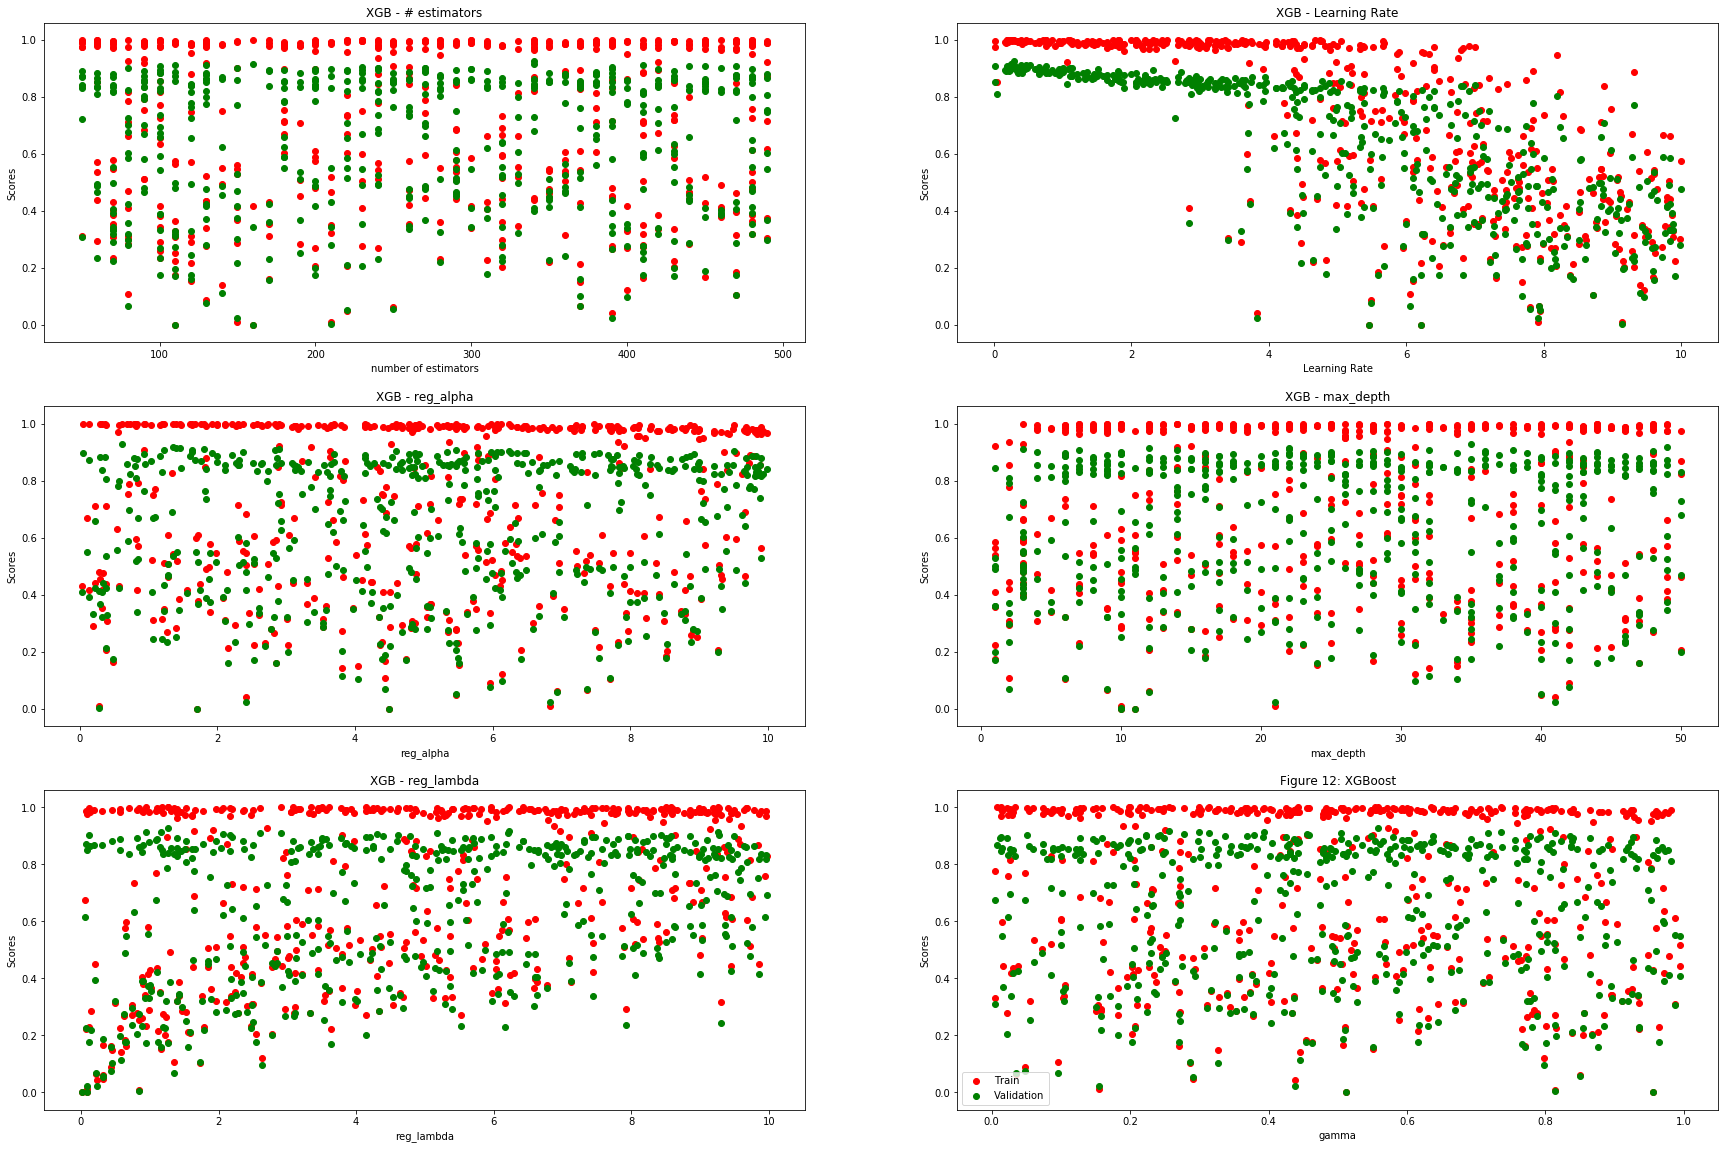

In [ ]:
# Plot validation score vs n_estimators
fig,ax = plt.subplots(3,2,figsize=[30,20])
ax[0,0].scatter(xgbAttributes['n_estimators'], xgbAttributes['train_means'], marker ='o', color='r')
ax[0,0].scatter(xgbAttributes['n_estimators'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[0,0].set_xlabel('number of estimators')
ax[0,0].set_ylabel('Scores')
ax[0,0].set_title('XGB - # estimators')

# Plot validation score vs learning rate
ax[0,1].scatter(xgbAttributes['learning_rate'], xgbAttributes['train_means'], marker ='o', color='r')
ax[0,1].scatter(xgbAttributes['learning_rate'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[0,1].set_xlabel('Learning Rate')
ax[0,1].set_ylabel('Scores')
ax[0,1].set_title('XGB - Learning Rate')

# Plot validation score vs reg_alpha
ax[1,0].scatter(xgbAttributes['reg_alpha'], xgbAttributes['train_means'], marker ='o', color='r')
ax[1,0].scatter(xgbAttributes['reg_alpha'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[1,0].set_xlabel('reg_alpha')
ax[1,0].set_ylabel('Scores')
ax[1,0].set_title('XGB - reg_alpha')

# Plot validation score vs max_depth
ax[1,1].scatter(xgbAttributes['max_depth'], xgbAttributes['train_means'], marker ='o', color='r')
ax[1,1].scatter(xgbAttributes['max_depth'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[1,1].set_xlabel('max_depth')
ax[1,1].set_ylabel('Scores')
ax[1,1].set_title('XGB - max_depth')

# Plot validation score vs reg_lambda
ax[2,0].scatter(xgbAttributes['reg_lambda'], xgbAttributes['train_means'], marker ='o', color='r')
ax[2,0].scatter(xgbAttributes['reg_lambda'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[2,0].set_xlabel('reg_lambda')
ax[2,0].set_ylabel('Scores')
ax[2,0].set_title('XGB - reg_lambda')

# Plot validation score vs gamma
ax[2,1].scatter(xgbAttributes['gamma'], xgbAttributes['train_means'], marker ='o', color='r')
ax[2,1].scatter(xgbAttributes['gamma'], xgbAttributes['test_means'], marker = 'o', color = 'g')
ax[2,1].set_xlabel('gamma')
ax[2,1].set_ylabel('Scores')
ax[2,1].set_title('XGB - gamma')


plt.legend(['Train', 'Validation'])
plt.title('Figure 12: XGBoost')
plt.show()

In [ ]:
xgbAttributes = xgbAttributes[(xgbAttributes['train_means'] != 1) & (xgbAttributes['test_means'] >= 0.80)]
xgbAttributes['diff'] = xgbAttributes['train_means'] - xgbAttributes['test_means']
xgbAttributes.sort_values(by=['test_means'], ascending=False)

,rank,test_means,test_stds,train_means,train_stds,n_estimators,learning_rate,reg_alpha,max_depth,reg_lambda,gamma,diff
13,2,0.978248,0.008417,0.999914,0.000172,440,0.01,1.63,14,2.61,0.8141,0.021666
55,5,0.976904,0.010867,0.999224,0.000323,180,0.16,7.54,16,5.96,0.7917,0.022320
76,6,0.975899,0.009160,0.999052,0.000173,240,0.21,8.93,30,1.39,0.8398,0.023153
70,7,0.964197,0.005480,0.998620,0.000634,60,0.80,8.30,23,6.42,0.5655,0.034423
58,8,0.961736,0.006798,0.999311,0.000440,470,0.95,7.72,35,3.86,0.4055,0.037574
61,9,0.956521,0.006600,0.999052,0.000422,140,1.22,6.57,39,6.04,0.8367,0.042531
93,10,0.954227,0.004246,0.999483,0.000322,250,1.30,5.61,23,4.60,0.2985,0.045256
0,11,0.951941,0.013215,0.997756,0.000693,360,1.14,7.29,12,2.36,0.8226,0.045815
5,12,0.951231,0.006313,0.999311,0.000751,210,1.51,6.49,36,9.49,0.3377,0.048080
7,13,0.948479,0.008407,0.973049,0.001317,420,1.06,7.91,1,1.92,0.2499,0.024570


In [ ]:
xgbAllFeaturesParameters = {'name':'XGB', 'model': XGBClassifier(n_estimators=440, learning_rate=0.01, reg_alpha=1.63, max_depth=14, reg_lambda=2.61, gamma=0.8141)}

# Final Model Comparison

In [ ]:
X_smote_mms =  pd.DataFrame(scaler.transform(X_smote_), index=X_smote_.index, columns=X_smote_.columns)
X_train_smote_mms =  pd.DataFrame(scaler.transform(X_train_smote), index=X_train_smote.index, columns=X_train_smote.columns)
X_valid_smote_mms =  pd.DataFrame(scaler.transform(X_valid_smote), index=X_valid_smote.index, columns=X_valid_smote.columns)
X_test_smote_mms = pd.DataFrame(scaler.transform(X_test_smote), index=X_test_smote.index, columns=X_test_smote.columns)

SVM RBF


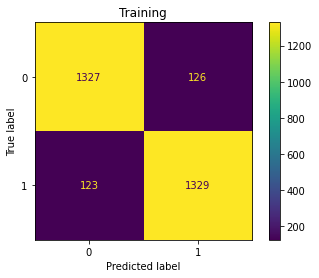

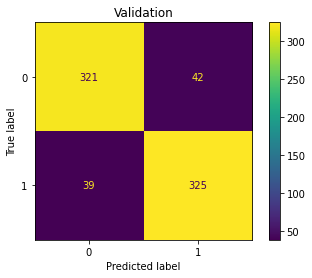

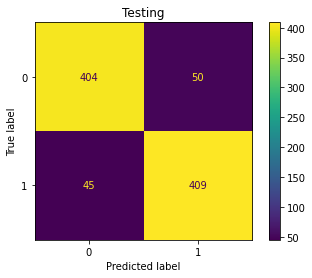

Random


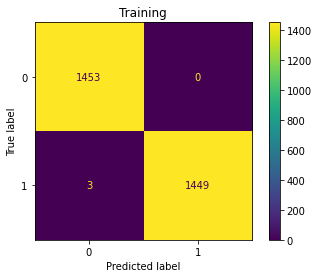

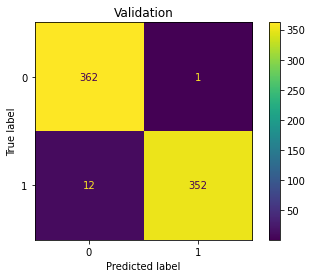

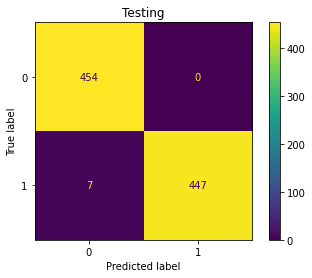

KNN


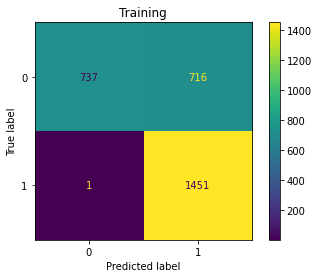

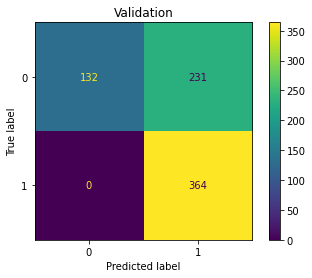

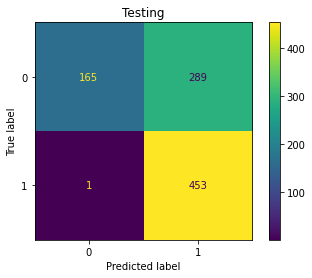

XGB


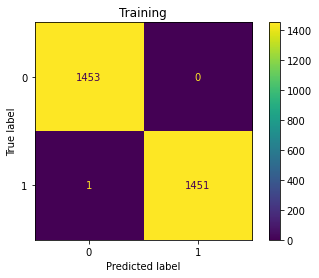

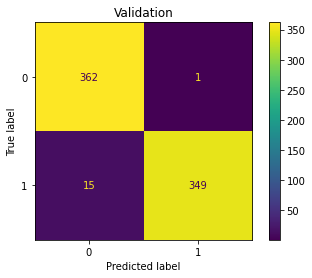

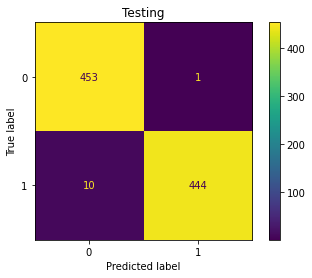

,Name,Train F1 Positive,Train MCC Score,Train Precision,Train Recall,Validation F1 Positive,Validation MCC Score,Validation Precision,Validation Recall,Test F1 Positive,Test MCC Score,Test Precision,Test Recall
0,SVM RBF,91.434469,82.857330,91.340206,91.528926,88.919289,77.718996,88.555858,89.285714,89.594743,79.079686,89.106754,79.079686
1,Random,99.896587,99.793672,100.000000,99.793388,98.186890,96.467978,99.716714,96.703297,99.223085,98.469855,100.000000,98.469855
2,KNN,80.187897,58.179539,66.958929,99.931129,75.912409,47.165654,61.176471,100.000000,75.752508,46.729147,61.051213,46.729147
3,XGB,99.965553,99.931177,100.000000,99.931129,97.759104,95.669550,99.714286,95.879121,98.776418,97.596271,99.775281,97.596271


In [ ]:
# collect all the models in a list
all_models = [svcRbfAllFeaturesParameter, RandomAllFeaturesParameter, KnnAllFeaturesParameter, xgbAllFeaturesParameters]

smote_sf_ht = pd.DataFrame()
for i in all_models:
  smote_sf_ht = modelling(i, smote_sf_ht, X_train_smote_mms[selected_features], y_train_smote, X_valid_smote_mms[selected_features], 
                          y_valid_smote, X_test_smote_mms[selected_features], y_test_smote)
smote_sf_ht

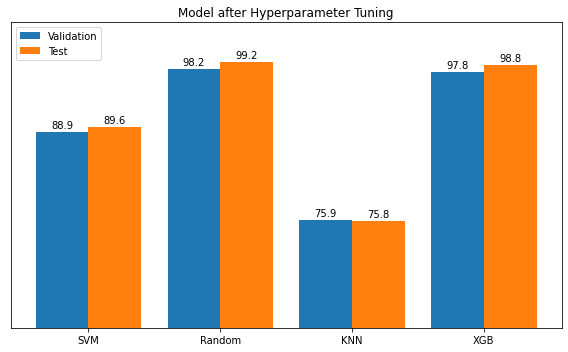

In [ ]:
model = ['SVM', 'Random', 'KNN', 'XGB']
X_axis = np.arange(len(model))

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(X_axis-0.2, smote_sf_ht['Validation F1 Positive'], 0.4)     #color=['yellow', 'green', 'blue']
plt.bar(X_axis+0.2, smote_sf_ht['Test F1 Positive'],0.4)

for bar in ax.patches:
    value = round(bar.get_height(),1)
    text = f'{value}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + value + 0.5
    ax.text(text_x, text_y, text, ha='center',color='black',size=10)


plt.xticks(X_axis,model)
plt.yticks([])
plt.title('Model after Hyperparameter Tuning')
plt.legend(['Validation', 'Test'], loc='upper left')
plt.ylim([60,105])
plt.tight_layout()
plt.show()